## Feature Engineering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, make_scorer, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

from sklearn.decomposition import PCA

from ydata_profiling import ProfileReport

In [ ]:
import warnings
import pandas as pd
pd.set_option('mode.chained_assignment', None)

In [1]:
def gold_to_yield(df):
    teny_returns = df["US-10Y"].pct_change()
    # gold_returns = df["Gold"]
    gold_returns = df["Gold"].pct_change()
    teny_returns = teny_returns.fillna(0)
    gold_returns = gold_returns.fillna(0)
    epsilon = 1e-10
    df["gold_r__div__teny_r"] = np.divide(gold_returns, (teny_returns + 1e-10))
    return df

In [2]:
def treasury_equity(df):
    for treasury in ["US-2Y", "US-5Y", "US-10Y", "US-30Y"]:
        economy = df[treasury].pct_change()
        equity = df["SP500"].pct_change()
        economy = economy.fillna(0)
        equity = equity.fillna(0)
        df[f"{treasury}_equity_interaction"] = np.multiply(economy, equity)
    return df

In [3]:
def vola(df):
    volatility = df[raw_price_cols].pct_change().rolling(window=252).std()*(252**0.5)
    new_names = [(i,i+'_vol') for i in df[raw_price_cols].columns.values]
    volatility.rename(columns = dict(new_names), inplace=True)
    df = pd.concat((df, volatility), axis=1)
    return df

In [4]:
def sma(df):
    window=20
    column='Gold'
    df[f'{column}_SMA'] = df[column].rolling(window=window).mean()
    return df

In [5]:
def price_oscillator(df):
    short_window = 12
    long_window = 26
    column="EuroStoxx50"
    df[f'{column}_Price_Oscillator'] = df[column].ewm(span=short_window).mean() - df[column].ewm(span=long_window).mean()
    return df

In [6]:
def rsi(df):
    window = 14
    df['Russel2000_RSI'] = 100 - (100 / (1 + df['Russel2000'].diff(1).rolling(window=window, min_periods=1).apply(lambda x: x[x > 0].mean()) / -df['SP500'].diff(1).rolling(window=window, min_periods=1).apply(lambda x: x[x < 0].mean())))
    return df


In [ ]:
raw_prices = pd.read_csv("https://storage.googleapis.com/sovai-public/random/assetalloc.csv", sep=';', parse_dates=True, index_col='Dates', dayfirst=True)
df = raw_prices.sort_values(by='Dates')
raw_price_cols = df.columns
df["target"] = df["SP500"].pct_change().shift(-1)
df["target"] = np.where(df["target"]>0,1,0)

In [36]:
# Feature engineering for present or past features (essentially, features that do not lead to any data leakage

df = sma(df)
df = price_oscillator(df)
df = rsi(df)
df = vola(df)
df = treasury_equity(df)
df = gold_to_yield(df)
df

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,...,Russel2000_vol,EuroStox_Small_vol,FTSE_Small_vol,MSCI_EM_vol,CRB_vol,US-2Y_equity_interaction,US-5Y_equity_interaction,US-10Y_equity_interaction,US-30Y_equity_interaction,gold_r__div__teny_r
Dates,,,,,,,,,,,,,,,,,,,,,
1989-02-01,2039.70,875.470,297.09,392.50,99.081,99.039,99.572,100.000,100.031,100.345,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
1989-02-02,2043.40,878.080,296.84,392.00,98.898,99.117,99.278,99.692,100.000,100.314,...,NaN,NaN,NaN,NaN,NaN,2.607829e-07,2.599668e-07,5.244780e-07,2.559093e-07,2.043879
1989-02-03,2069.90,884.090,296.97,388.75,98.907,99.002,99.145,99.178,99.812,100.062,...,NaN,NaN,NaN,NaN,NaN,-8.233392e-07,-1.100170e-06,-4.161958e-07,-8.036502e-07,8.724099
1989-02-06,2044.30,885.490,296.04,388.00,98.484,98.502,98.510,97.739,99.812,100.062,...,NaN,NaN,NaN,NaN,NaN,-0.000000e+00,-0.000000e+00,3.940874e-06,7.696842e-06,1.533094
1989-02-07,2072.80,883.820,299.63,392.75,98.438,98.312,98.292,97.688,99.906,100.251,...,NaN,NaN,NaN,NaN,NaN,1.142061e-05,2.290534e-05,4.210924e-05,7.457608e-05,3.525563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-06,7617.70,3448.490,2759.82,1254.84,90.036,149.257,211.743,306.533,122.817,143.926,...,0.132813,0.104971,0.071058,0.122754,0.044144,2.279473e-06,5.306854e-06,6.644273e-06,2.692870e-05,-3.398703
2018-07-09,7687.99,3460.442,2784.17,1261.56,90.022,149.158,211.487,303.672,122.779,143.745,...,0.132929,0.105101,0.071093,0.123647,0.044156,-2.729879e-06,-1.109577e-05,-2.201474e-05,-4.129691e-05,-2.146276
2018-07-10,7692.04,3473.311,2793.84,1254.45,90.004,149.059,211.377,303.464,122.702,143.610,...,0.132961,0.104675,0.071134,0.123645,0.043784,-2.178198e-06,-3.261908e-06,-3.796360e-06,-3.674408e-06,5.156144


In [37]:
df_pct_changes = df.copy()

# Calculate percent changes for specified columns
for column in raw_price_cols:
    if column != 'target':  # Exclude the target column
        df[column] = df_pct_changes[column].pct_change()
df

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,...,Russel2000_vol,EuroStox_Small_vol,FTSE_Small_vol,MSCI_EM_vol,CRB_vol,US-2Y_equity_interaction,US-5Y_equity_interaction,US-10Y_equity_interaction,US-30Y_equity_interaction,gold_r__div__teny_r
Dates,,,,,,,,,,,,,,,,,,,,,
1989-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
1989-02-02,0.001814,0.002981,-0.000841,-0.001274,-0.001847,0.000788,-0.002953,-0.003080,-0.000310,-0.000309,...,NaN,NaN,NaN,NaN,NaN,2.607829e-07,2.599668e-07,5.244780e-07,2.559093e-07,2.043879
1989-02-03,0.012969,0.006844,0.000438,-0.008291,0.000091,-0.001160,-0.001340,-0.005156,-0.001880,-0.002512,...,NaN,NaN,NaN,NaN,NaN,-8.233392e-07,-1.100170e-06,-4.161958e-07,-8.036502e-07,8.724099
1989-02-06,-0.012368,0.001584,-0.003132,-0.001929,-0.004277,-0.005050,-0.006405,-0.014509,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,-0.000000e+00,-0.000000e+00,3.940874e-06,7.696842e-06,1.533094
1989-02-07,0.013941,-0.001886,0.012127,0.012242,-0.000467,-0.001929,-0.002213,-0.000522,0.000942,0.001889,...,NaN,NaN,NaN,NaN,NaN,1.142061e-05,2.290534e-05,4.210924e-05,7.457608e-05,3.525563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-06,0.001904,0.002201,0.008481,-0.002663,0.000078,0.000375,0.001878,-0.002399,0.000269,0.000626,...,0.132813,0.104971,0.071058,0.122754,0.044144,2.279473e-06,5.306854e-06,6.644273e-06,2.692870e-05,-3.398703
2018-07-09,0.009227,0.003466,0.008823,0.005355,-0.000155,-0.000663,-0.001209,-0.009333,-0.000309,-0.001258,...,0.132929,0.105101,0.071093,0.123647,0.044156,-2.729879e-06,-1.109577e-05,-2.201474e-05,-4.129691e-05,-2.146276
2018-07-10,0.000527,0.003719,0.003473,-0.005636,-0.000200,-0.000664,-0.000520,-0.000685,-0.000627,-0.000939,...,0.132961,0.104675,0.071134,0.123645,0.043784,-2.178198e-06,-3.261908e-06,-3.796360e-06,-3.674408e-06,5.156144


In [38]:
from sklearn.model_selection import train_test_split
y = df.pop("target")
X = df.copy()

X_train = X[X.index.astype(str)<'2018-01-01']
y_train = y[X_train.index]
X_test = X[~X.index.isin(X_train.index)]
y_test = y[X_test.index]

In [39]:
X_train.shape

(7543, 42)

We have too many features (42) and we know we will run into the curse of dimensionality. Thus, we need to start brainstorming features that we can drop without losing information. Thus, we have used a few common EDA techniques to understand this better:

In [40]:
pd.set_option('display.precision', 3)
X_train.describe()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,...,Russel2000_vol,EuroStox_Small_vol,FTSE_Small_vol,MSCI_EM_vol,CRB_vol,US-2Y_equity_interaction,US-5Y_equity_interaction,US-10Y_equity_interaction,US-30Y_equity_interaction,gold_r__div__teny_r
count,7.542e+03,7.542e+03,7.542e+03,7.542e+03,7.542e+03,7.542e+03,7.542e+03,7.542e+03,7.542e+03,7.542e+03,...,7291.000,7291.000,7291.000,7291.000,7291.000,7.543e+03,7.543e+03,7.543e+03,7.543e+03,7.543e+03
mean,2.338e-04,2.702e-04,3.499e-04,2.067e-04,-9.816e-06,5.657e-05,1.045e-04,1.647e-04,2.929e-05,5.480e-05,...,0.184,0.153,0.094,0.168,0.062,-1.813e-06,-5.330e-06,-8.858e-06,-1.664e-05,-5.404e+04
std,1.076e-02,1.313e-02,1.082e-02,9.745e-03,8.787e-04,2.033e-03,3.591e-03,6.911e-03,1.013e-03,2.654e-03,...,0.087,0.060,0.038,0.063,0.020,1.898e-05,4.896e-05,8.226e-05,1.519e-04,1.938e+07
min,-8.849e-02,-8.617e-02,-9.035e-02,-9.663e-02,-8.351e-03,-1.445e-02,-1.996e-02,-5.292e-02,-9.866e-03,-2.270e-02,...,0.074,0.072,0.031,0.069,0.035,-5.661e-04,-1.230e-03,-1.863e-03,-4.216e-03,-6.894e+08
25%,-5.061e-03,-5.682e-03,-4.081e-03,-3.940e-03,-3.904e-04,-9.590e-04,-1.842e-03,-3.355e-03,-3.927e-04,-1.337e-03,...,0.124,0.112,0.068,0.132,0.048,-2.217e-06,-6.936e-06,-1.194e-05,-1.984e-05,-1.687e+00
50%,6.158e-05,3.483e-04,2.493e-04,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,...,0.164,0.142,0.092,0.160,0.061,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00
75%,5.732e-03,6.494e-03,5.255e-03,4.626e-03,3.715e-04,1.135e-03,2.121e-03,3.888e-03,4.706e-04,1.551e-03,...,0.225,0.177,0.111,0.187,0.068,1.346e-06,4.264e-06,7.867e-06,1.380e-05,1.780e+00
max,9.839e-02,1.100e-01,1.158e-01,7.661e-02,1.014e-02,1.306e-02,2.332e-02,3.408e-02,9.817e-03,2.190e-02,...,0.534,0.373,0.235,0.442,0.147,1.839e-04,4.569e-04,8.627e-04,1.319e-03,6.126e+08


The following profiling technique is very helpful in getting an initial understanding of the input features data. However, given the heaviness of the data, it is taking a lot of time to run. 

In [ ]:
profile = ProfileReport(X_train, title="Profiling Report")
profile

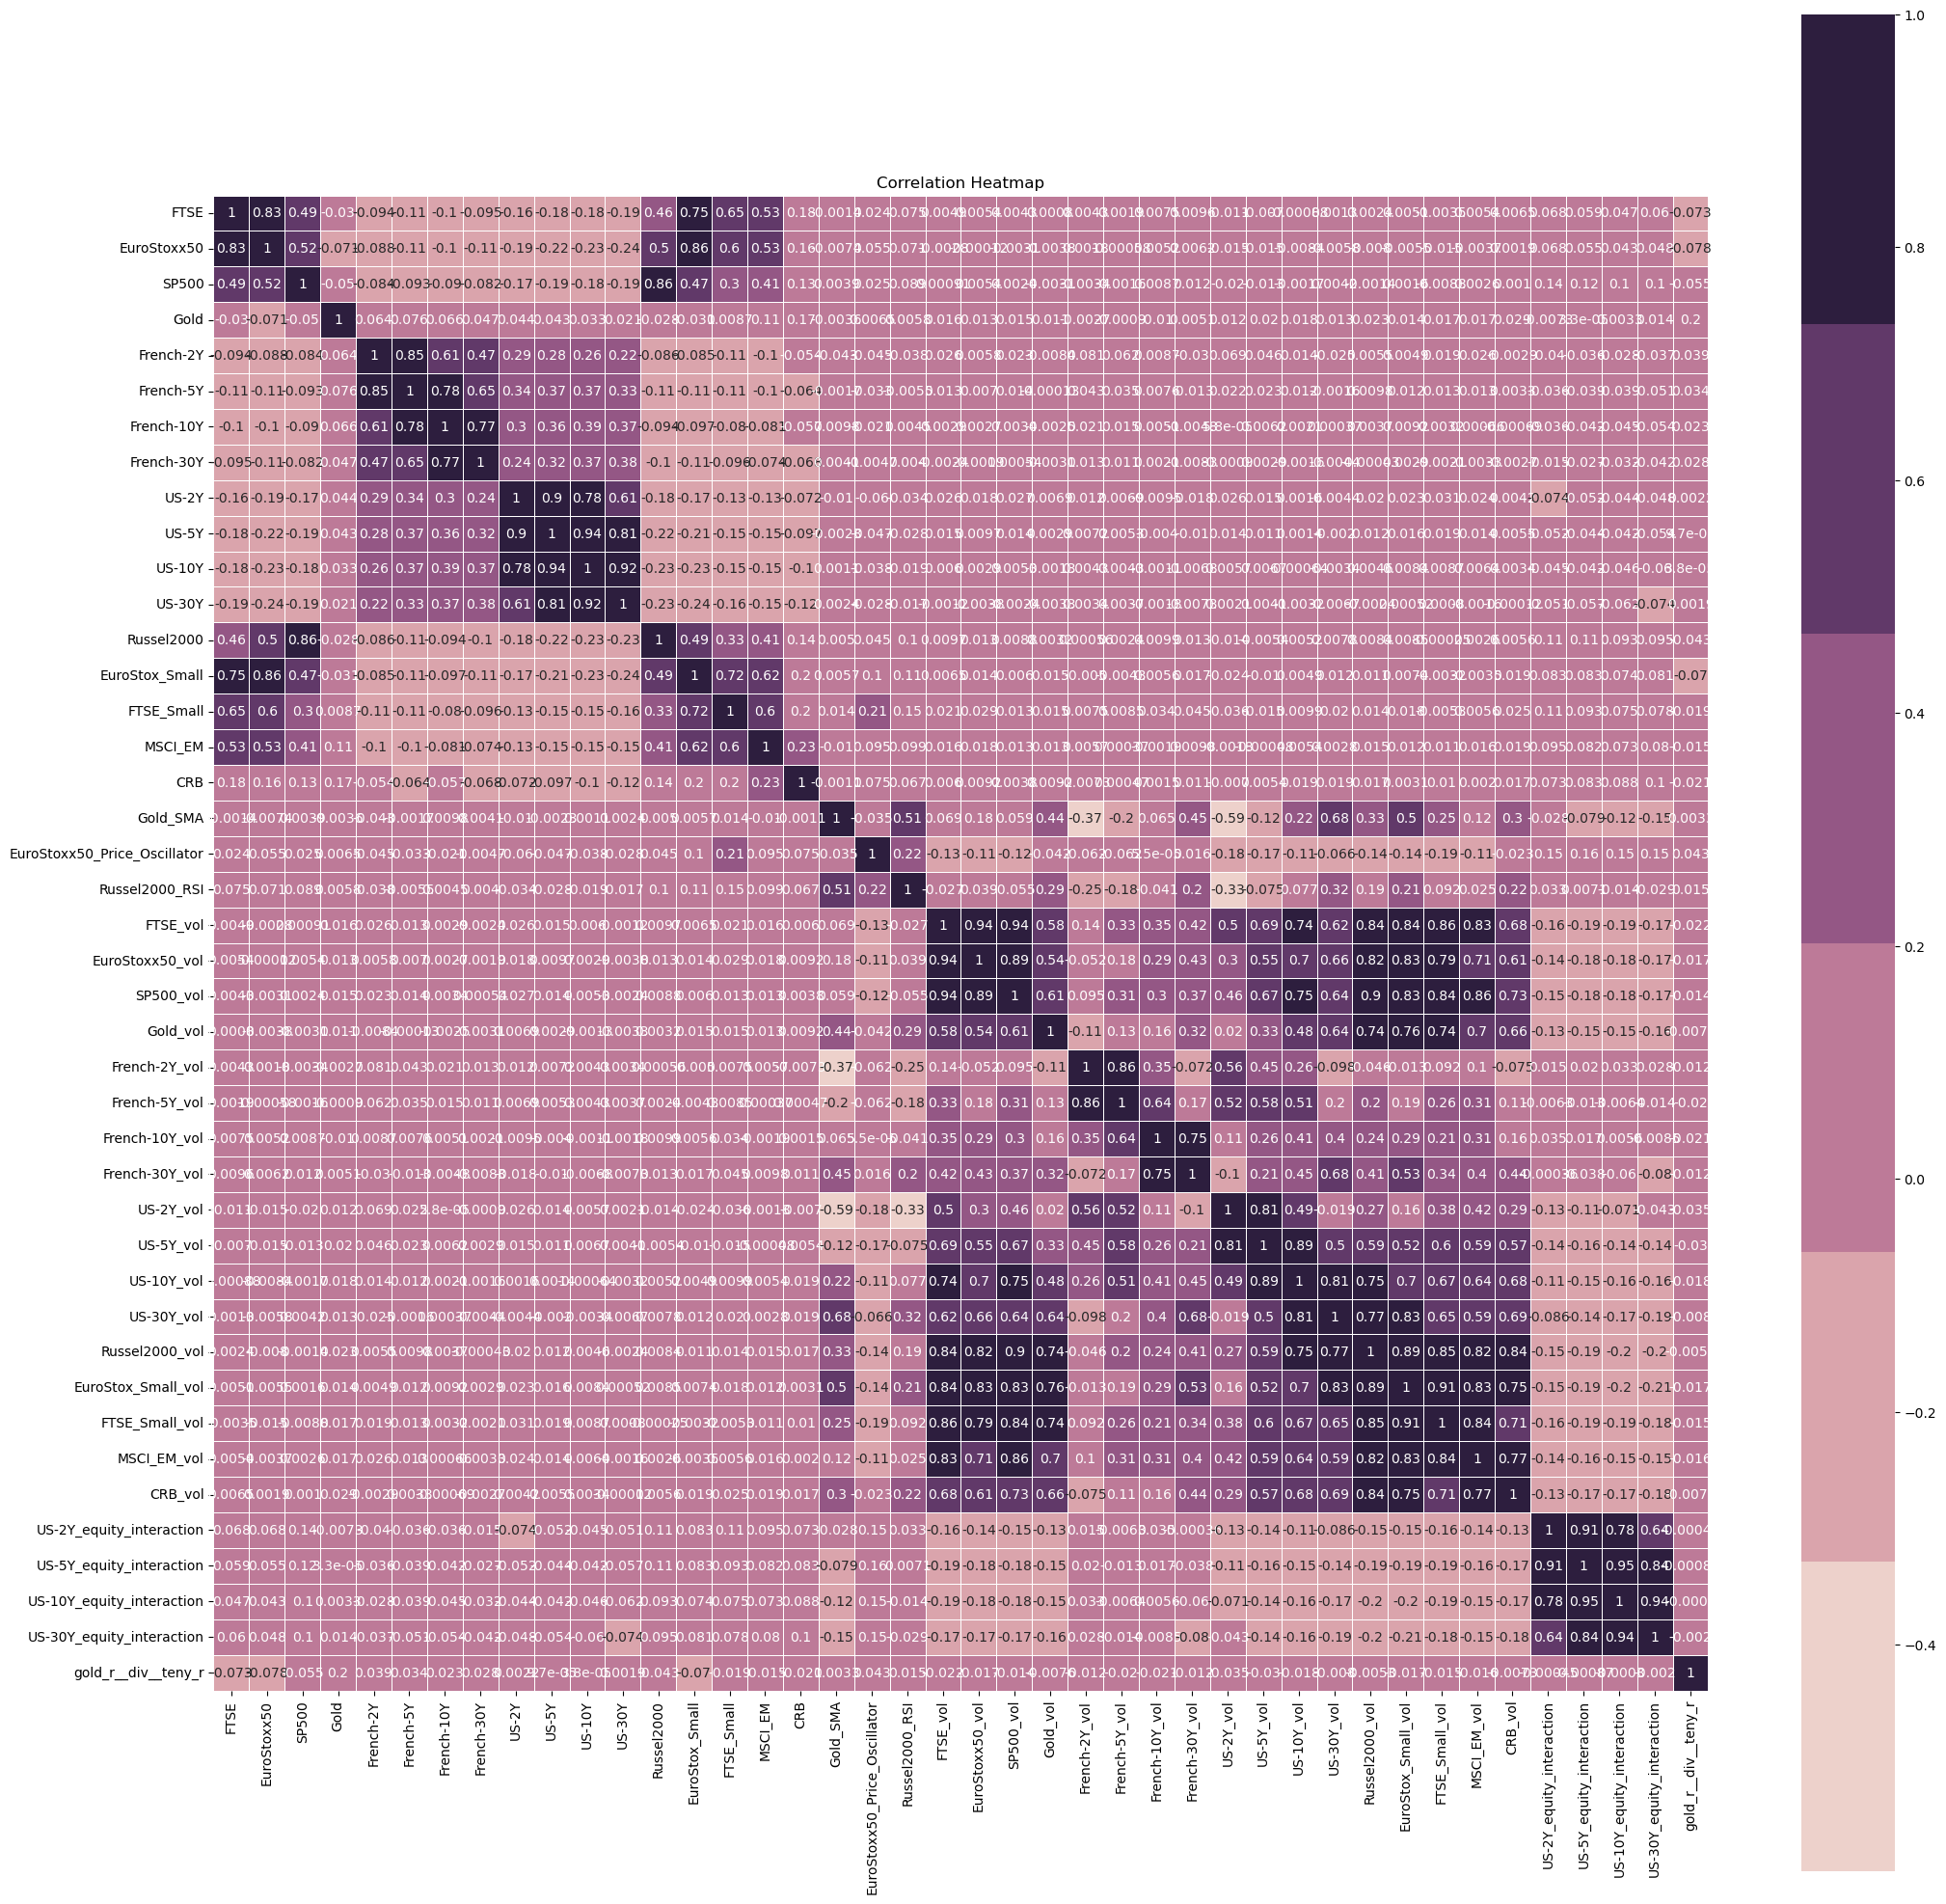

In [41]:
correlation_matrix = X_train.corr()

# Create a heatmap
plt.figure(figsize=(25,25))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, square=True,cmap=sns.cubehelix_palette(as_cmap=False))
plt.title("Correlation Heatmap")
plt.show()

From the correlation matrix, we can make the following obversations: 
1. FTSE and EuroStoxx data is highly correlated and understandably so since they indexes based in London and the European Union respectively. 
2. The treasury returns over different time periods is correlated.
3. Volatility in Gold, S&P500, EuroStoxx50, FTSE, FTSE_small, and Russel2000 are highly correlated. 

This correlation matrix gives us a rough idea of the features we can drop while still retaining important information. 

In [46]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_train_imputed

array([[ 2.33812822e-04,  2.70163122e-04,  3.49907790e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.81399225e-03,  2.98125578e-03, -8.41495843e-04, ...,
         5.24478018e-07,  2.55909307e-07,  2.04387860e+00],
       [ 1.29685818e-02,  6.84447886e-03,  4.37946368e-04, ...,
        -4.16195802e-07, -8.03650173e-07,  8.72409876e+00],
       ...,
       [ 3.69040626e-03, -9.04770066e-04,  7.90897221e-04, ...,
         3.77792537e-06,  1.06339200e-05,  5.82739050e-01],
       [ 2.88688149e-04, -7.28555840e-03,  1.83402793e-03, ...,
        -3.19739876e-06, -4.00066108e-06, -3.57251202e+00],
       [ 8.51253070e-03, -5.77276283e-03, -5.18317867e-03, ...,
        -9.88757585e-06, -1.78359213e-05,  3.79560874e+00]])

In [47]:
X_test_imputed = imputer.transform(X_test)
X_test_imputed

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.16014397e-03, -3.93183263e-03,  8.30338007e-03, ...,
        -3.94683325e-05, -1.15239644e-04, -1.55591359e+00],
       [ 3.00859037e-03,  5.64296412e-03,  6.39881891e-03, ...,
         1.12070172e-05,  3.44070779e-05,  1.37403892e+00],
       ...,
       [ 5.26795690e-04,  3.71888909e-03,  3.47320746e-03, ...,
        -3.79636047e-06, -3.67440783e-06,  5.15614369e+00],
       [-1.30108528e-02, -1.46727431e-02, -7.09417862e-03, ...,
        -1.77646811e-05, -3.87380005e-05, -2.58810490e+00],
       [ 7.82011496e-03,  6.76290079e-03,  8.74903570e-03, ...,
        -6.85613130e-06, -1.05470396e-05, -1.02388588e+00]])

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# X_train_scaled, X_test_scaled = pca_first(X_train_scaled, X_test_scaled)
# X_train, X_test = tsne(X_train, X_test)
# X_train, X_test = autoencoder(X_train, X_test)
# X_train, X_test = umap(X_train, X_test)


We will use the following graph to estimate how many principal components we should define for the PCA model.  
Source: https://mikulskibartosz.name/pca-how-to-choose-the-number-of-components

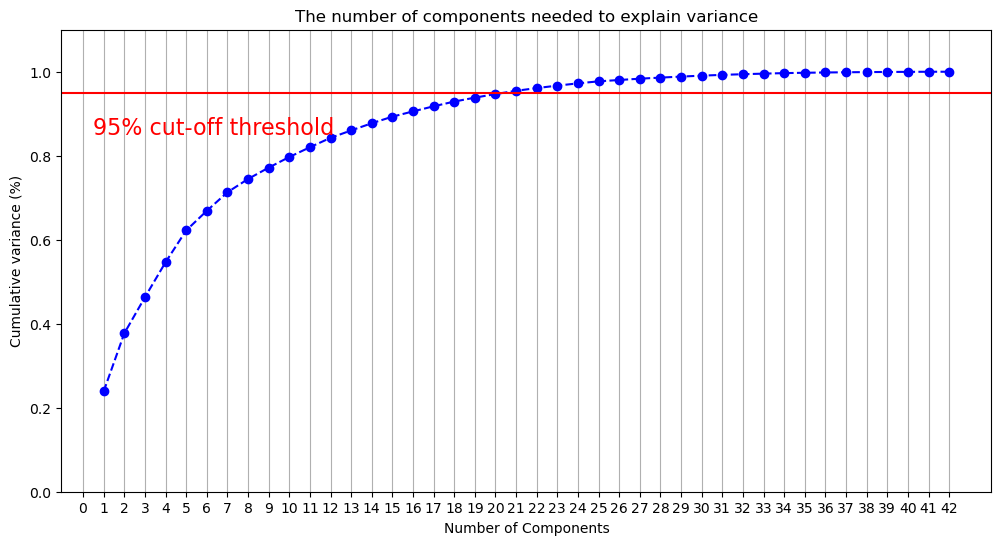

In [53]:
pca = PCA().fit(X_train_scaled)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)

fig, ax = plt.subplots()
xi = np.arange(1, 43, step=1)  # Adjust the length of xi to match the length of y
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 43, step=1))  # Adjust the range to match the length of xi
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=16)

ax.grid(axis='x')
plt.show()

This graph tells us that we need 21 principal components to get 95% of the variance. 

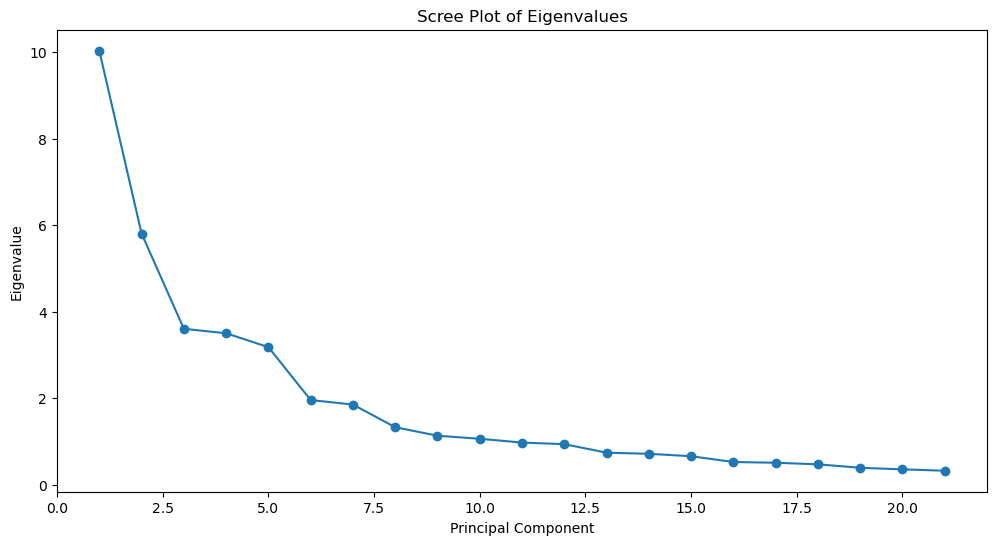

In [62]:
pca = PCA(21)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Obtain the eigenvalues
eigenvalues = pca.explained_variance_

# Plot the scree plot
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot of Eigenvalues')
plt.show()

In [56]:
# Apply PCA and transform data
pca = PCA(21)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
loadings = pca.components_
print("Feature Loadings:\n", loadings)

Feature Loadings:
 [[-3.73723470e-03 -6.79770631e-03 -6.61165214e-03  6.32937685e-03
   9.50805857e-03  9.51228290e-03  6.66751339e-03  4.10625720e-03
   1.15081901e-02  9.76637290e-03  7.82754518e-03  5.96401735e-03
  -4.00122640e-03 -3.61535806e-03 -7.60845504e-04 -1.20924032e-03
  -7.96693399e-04  9.24229505e-02 -4.97203022e-02  3.61899490e-02
   2.89602147e-01  2.70883460e-01  2.89003342e-01  2.28098612e-01
   3.96503053e-02  1.19856488e-01  1.27071634e-01  1.67921588e-01
   1.28644007e-01  2.32076078e-01  2.71420124e-01  2.57649442e-01
   2.92251656e-01  2.91842758e-01  2.83196748e-01  2.75739927e-01
   2.57463328e-01 -7.43041052e-02 -9.04008679e-02 -9.17104367e-02
  -9.02490727e-02 -6.20837275e-03]
 [-2.68732529e-01 -2.83412759e-01 -2.35716574e-01  2.12918780e-02
   1.86784686e-01  2.20860892e-01  2.13206344e-01  1.97771872e-01
   2.52978590e-01  2.84905979e-01  2.89413484e-01  2.76428671e-01
  -2.42902426e-01 -2.87772357e-01 -2.43362661e-01 -2.31888775e-01
  -1.07276823e-01 -2.0

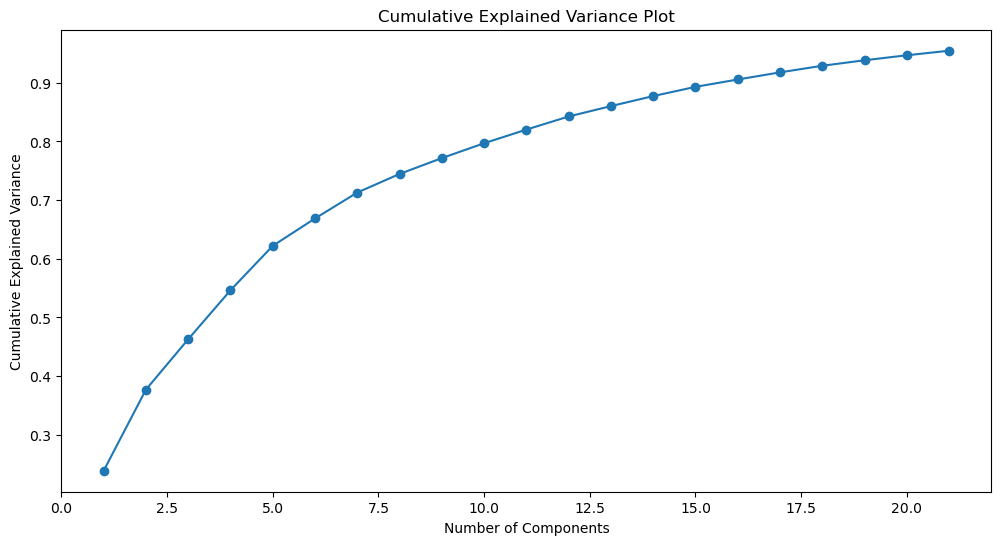

In [57]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.show()

To understand how much each feature contributes to the principal components:

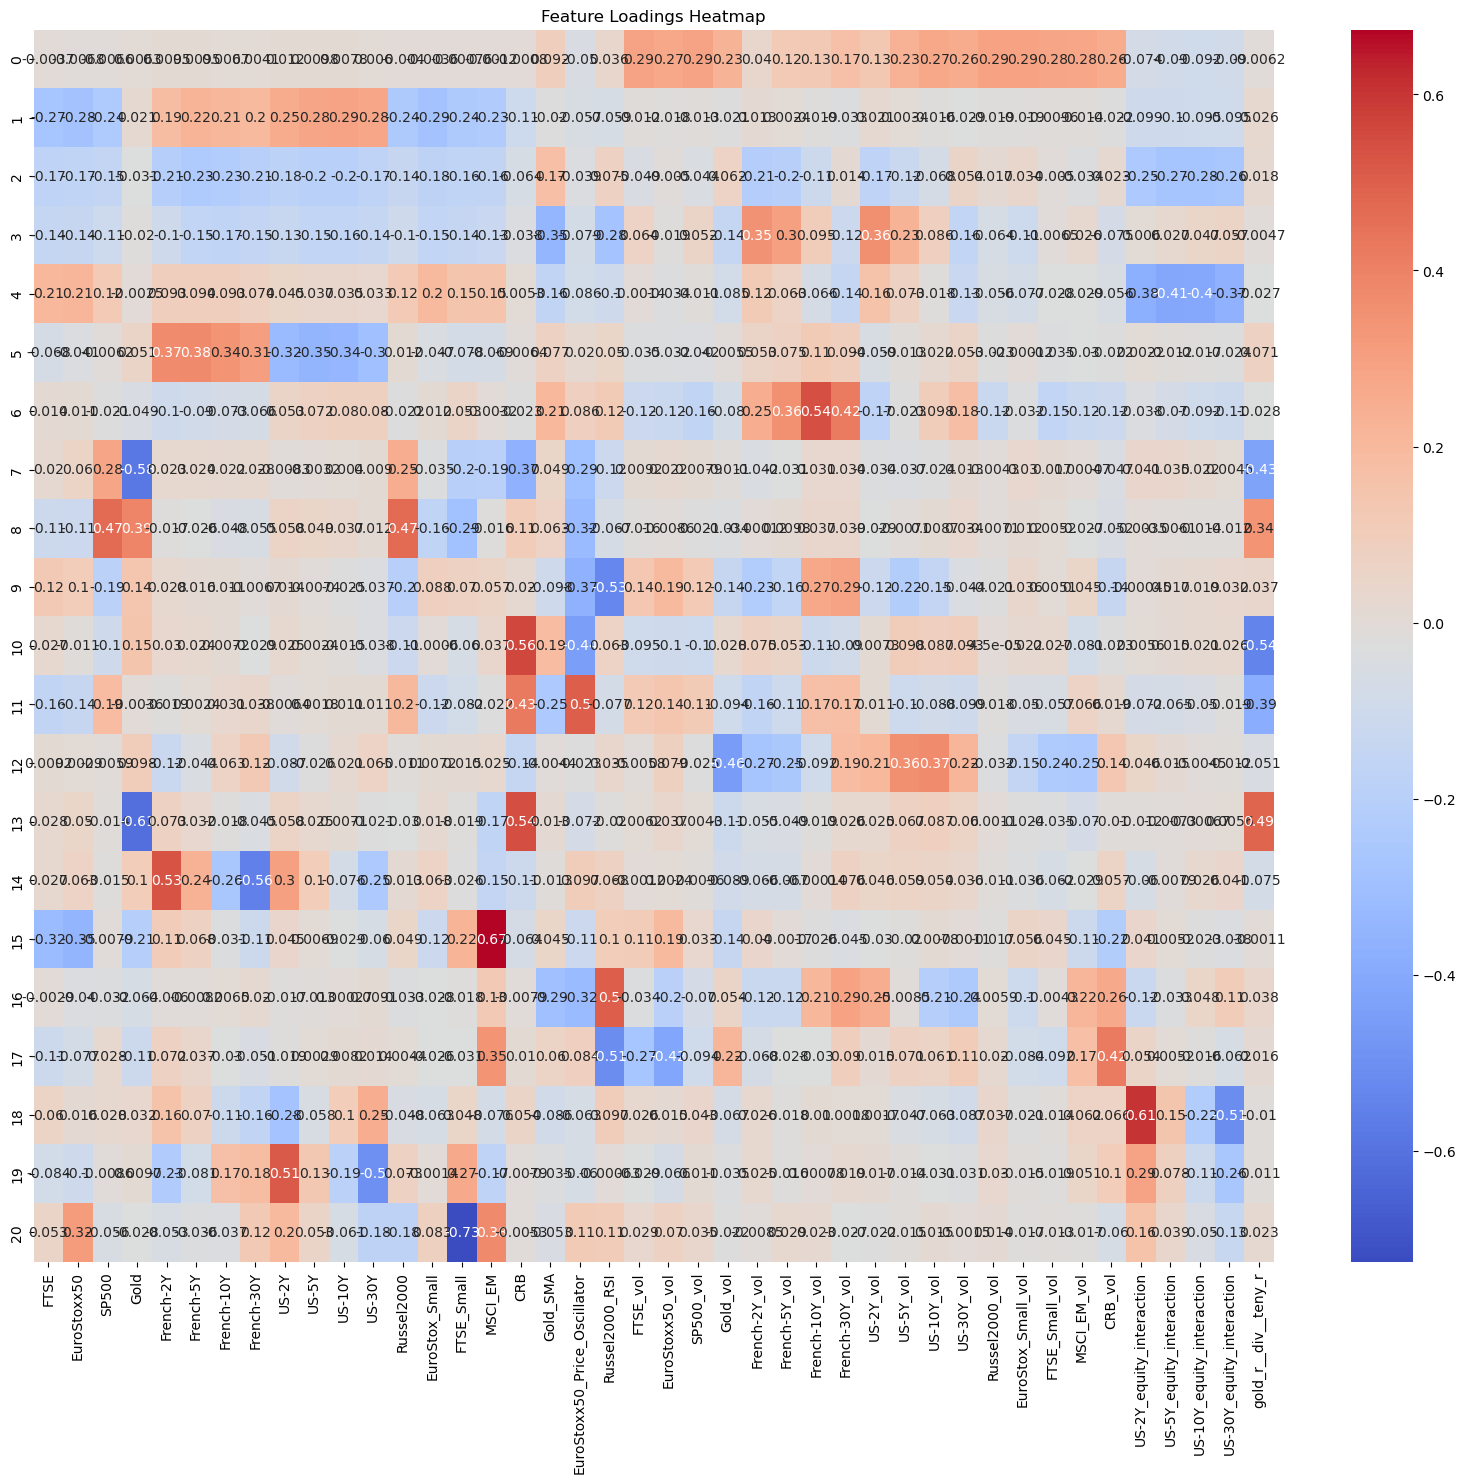

In [61]:
import seaborn as sns

plt.figure(figsize=(20, 16))
sns.heatmap(loadings, annot=True, cmap='coolwarm', xticklabels=X_train.columns)
plt.title('Feature Loadings Heatmap')
plt.show()

In [82]:
def create_lstm_model(units=50, epochs=10, batch_size=32):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train_pca.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train_pca[:, :, np.newaxis], y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    return model

# Fine-tune hyperparameters manually
best_accuracy = 0
best_params = None

for units in [50, 100]:
    for epochs in [10, 20]:
        for batch_size in [32, 64]:
            model = create_lstm_model(units=units, epochs=epochs, batch_size=batch_size)
            y_pred = model.predict(X_test_pca[:, :, np.newaxis])
            accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'units': units, 'epochs': epochs, 'batch_size': batch_size}

# Train the best model
final_model = create_lstm_model(**best_params)

# Make predictions on the test set
y_final_pred = final_model.predict(X_test_pca[:, :, np.newaxis])

# Evaluate the performance
print("Best Hyperparameters:", best_params)
print("Classification Report:\n", classification_report(y_test, (y_final_pred > 0.5).astype(int)))

5/5 [==============================] - 0s 3ms/step
Best Hyperparameters: {'units': 100, 'epochs': 10, 'batch_size': 64}
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.15      0.22        62
           1       0.56      0.87      0.68        77

    accuracy                           0.55       139
   macro avg       0.52      0.51      0.45       139
weighted avg       0.52      0.55      0.48       139



In [87]:
y_final_pred_binary = (y_final_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_final_pred_binary)
print("Accuracy:", accuracy)
print("AUC:", roc_auc_score(y_test, y_final_pred))

Accuracy: 0.5467625899280576
AUC: 0.46899874319229157


Therefore, our PCA-LSTM Model is fine-tuned to these hyperparameters:
- units: 100
- epochs: 10
- batch_size: 64

We are able to achieve an accuracy of 0.547 and an ROC(AUC) score of 0.469. 